In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
# %matplotlib widget

In [102]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
from src.tools.dim_reduction import reduce_umap
import matplotlib.pyplot as plt
import contextily as ctx

In [103]:
tqdm.pandas()

In [159]:
place_name = "Wrocław,Poland"
place_dir_name = get_place_dir_name(place_name)
resolution = 8
buffered = True
edges = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"edges_drive_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
edges.tail(5)

,id,osmid,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,geometry
11591,9678,"[ 884068441, 769929444, 727134918, 508232269, ...",881e2040c7fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110..."
11592,9679,858291159,881e2040c7fffff,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110..."
11593,9680,875668659,881e204e09fffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058..."
11594,9681,"[ 923192968, 923192971 ]",881e20462dfffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160..."
11595,9682,925229680,881e20471dfffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.12107 51.14465, 17.12089 51.144..."


In [105]:
hexagons = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON").set_index("h3_id")
hexagons.head(5)

,coordinates,parent,children,resolution,geometry
h3_id,,,,,
881e204329fffff,"(51.120137612557066, 16.83370318850311)",871e20432ffffff,"{'891e2043297ffff', '891e2043283ffff', '891e20...",8,"POLYGON ((16.82861 51.12334, 16.82620 51.11906..."
881e204057fffff,"(51.1266068064378, 16.96150793540571)",871e20405ffffff,"{'891e2040563ffff', '891e2040567ffff', '891e20...",8,"POLYGON ((16.95642 51.12982, 16.95400 51.12554..."
881e204e19fffff,"(51.05692847359529, 17.080897969186214)",871e204e1ffffff,"{'891e204e197ffff', '891e204e187ffff', '891e20...",8,"POLYGON ((17.07582 51.06015, 17.07340 51.05587..."
881e204191fffff,"(51.06450244236346, 16.9954862528119)",871e20419ffffff,"{'891e2041903ffff', '891e204190bffff', '891e20...",8,"POLYGON ((16.99040 51.06772, 16.98799 51.06344..."
881e20462dfffff,"(51.15961470214516, 17.139051837176826)",871e20462ffffff,"{'891e20462cbffff', '891e20462d3ffff', '891e20...",8,"POLYGON ((17.13397 51.16283, 17.13154 51.15856..."


In [160]:
edges.columns

Index(['id', 'osmid', 'h3_id', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2',
       'lanes_3', 'lanes_4', 'lanes_5', 'lanes_6', 'lanes_7',
       'highway_living_street', 'highway_motorway', 'highway_motorway_link',
       'highway_primary', 'highway_primary_link', 'highway_residential',
       'highway_secondary', 'highway_secondary_link', 'highway_tertiary',
       'highway_tertiary_link', 'highway_trunk', 'highway_trunk_link',
       'highway_unclassified', 'maxspeed_10', 'maxspeed_100', 'maxspeed_110',
       'maxspeed_120', 'maxspeed_15', 'maxspeed_20', 'maxspeed_30',
       'maxspeed_40', 'maxspeed_50', 'maxspeed_60', 'maxspeed_70',
       'maxspeed_80', 'maxspeed_90', 'bridge_viaduct', 'bridge_yes',
       'access_delivery', 'access_destination', 'access_no',
       'access_permissive', 'access_yes', 'junction_roundabout', 'width_1.5',
       'width_2', 'width_2.5', 'width_3', 'width_4', 'width_4.5', 'width_6',
       'tunnel_building_passage', 'tunnel_yes', 'geometry'],
      d

In [107]:
hex_feautres = edges.drop(columns="id").groupby(by="h3_id").sum()
hex_feautres

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,junction_roundabout,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes
h3_id,,,,,,,,,,,,,,,,,,,,,
881e204001fffff,18,6,0,3,1,0,0,0,0,11,...,2,0,0,0,0,0,0,0,1,0
881e204003fffff,29,14,1,17,4,2,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
881e204005fffff,2,24,6,16,4,2,0,0,0,0,...,9,0,0,0,0,0,0,0,0,0
881e204007fffff,5,26,5,23,5,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
881e204009fffff,32,2,0,6,3,2,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881e2055a7fffff,0,2,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
881e2055b1fffff,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
881e2055b3fffff,32,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
hex_features_tfidf = tfidf(hex_feautres)
hex_features_tfidf

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,junction_roundabout,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes
h3_id,,,,,,,,,,,,,,,,,,,,,
881e204001fffff,0.523025,0.262253,0.000000,0.121138,0.053210,0.000000,0.0,0.0,0.0,0.547026,...,0.178793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120583,0.0
881e204003fffff,0.438910,0.318732,0.029995,0.357549,0.110861,0.070721,0.0,0.0,0.0,0.051805,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e204005fffff,0.025791,0.465555,0.153341,0.286728,0.094459,0.060258,0.0,0.0,0.0,0.000000,...,0.357069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e204007fffff,0.066838,0.522809,0.132461,0.427256,0.122395,0.031231,0.0,0.0,0.0,0.045756,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e204009fffff,0.610361,0.057383,0.000000,0.159037,0.104785,0.089127,0.0,0.0,0.0,0.228507,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881e2055a7fffff,0.000000,0.182244,0.000000,0.168361,0.221858,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e2055b1fffff,0.682869,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e2055b3fffff,0.732559,0.034436,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [143]:
embedding = reduce_umap(hex_features_tfidf, n_components=2, n_neighbors=5, metric="cosine")[0]


In [158]:
embedding_for_cluster = reduce_umap(hex_features_tfidf, n_components=4, n_neighbors=5, metric="euclidean")[0]

In [128]:
hex_features_tfidf

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,junction_roundabout,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes
h3_id,,,,,,,,,,,,,,,,,,,,,
881e204001fffff,0.523025,0.262253,0.000000,0.121138,0.053210,0.000000,0.0,0.0,0.0,0.547026,...,0.178793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120583,0.0
881e204003fffff,0.438910,0.318732,0.029995,0.357549,0.110861,0.070721,0.0,0.0,0.0,0.051805,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e204005fffff,0.025791,0.465555,0.153341,0.286728,0.094459,0.060258,0.0,0.0,0.0,0.000000,...,0.357069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e204007fffff,0.066838,0.522809,0.132461,0.427256,0.122395,0.031231,0.0,0.0,0.0,0.045756,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e204009fffff,0.610361,0.057383,0.000000,0.159037,0.104785,0.089127,0.0,0.0,0.0,0.228507,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881e2055a7fffff,0.000000,0.182244,0.000000,0.168361,0.221858,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e2055b1fffff,0.682869,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e2055b3fffff,0.732559,0.034436,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [157]:
embedding["cluster"] = cluster_hdbscan(embedding_for_cluster, min_cluster_size=30, metric="euclidean")[0]
fig = px.scatter(embedding, x="x_0", y="x_1", color="cluster", width=800, height=700)
fig.show()

In [112]:
embedding_df.index = hex_feautres.index
embedding_df.head(5)

,x,y,cluster
h3_id,,,
881e204001fffff,-5.068305,8.649967,0
881e204003fffff,1.746907,2.460576,1
881e204005fffff,4.955623,0.243860,-1
881e204007fffff,5.066030,-0.009095,-1
881e204009fffff,-1.981899,4.668792,-1


In [113]:
hexagons_clustered = hexagons.join(embedding_df).dropna()
hexagons_clustered.head(5)

,coordinates,parent,children,resolution,geometry,x,y,cluster
h3_id,,,,,,,,
881e204057fffff,"(51.1266068064378, 16.96150793540571)",871e20405ffffff,"{'891e2040563ffff', '891e2040567ffff', '891e20...",8,"POLYGON ((16.95642 51.12982, 16.95400 51.12554...",-4.331239,7.750504,0
881e204e19fffff,"(51.05692847359529, 17.080897969186214)",871e204e1ffffff,"{'891e204e197ffff', '891e204e187ffff', '891e20...",8,"POLYGON ((17.07582 51.06015, 17.07340 51.05587...",-3.012391,8.430160,-1
881e204191fffff,"(51.06450244236346, 16.9954862528119)",871e20419ffffff,"{'891e2041903ffff', '891e204190bffff', '891e20...",8,"POLYGON ((16.99040 51.06772, 16.98799 51.06344...",1.350618,-0.009964,1
881e20462dfffff,"(51.15961470214516, 17.139051837176826)",871e20462ffffff,"{'891e20462cbffff', '891e20462d3ffff', '891e20...",8,"POLYGON ((17.13397 51.16283, 17.13154 51.15856...",-3.952060,9.382726,0
881e204003fffff,"(51.11376590982746, 16.954267816743865)",871e20400ffffff,"{'891e2040023ffff', '891e2040027ffff', '891e20...",8,"POLYGON ((16.94918 51.11698, 16.94677 51.11270...",1.746907,2.460576,1


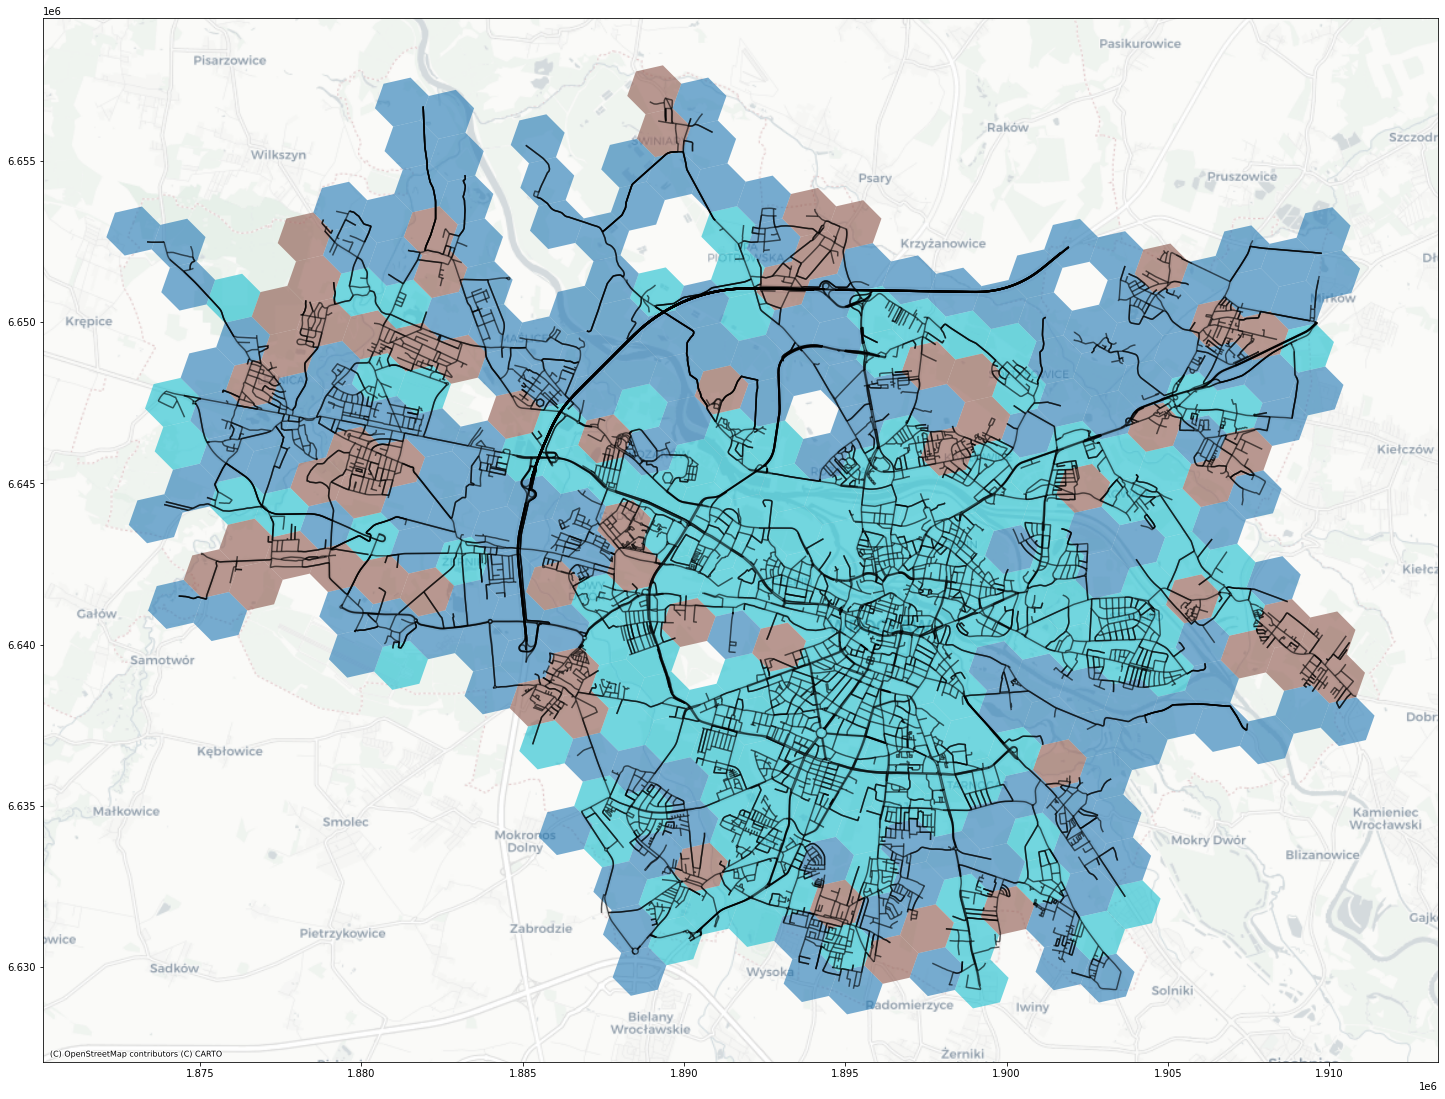

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(25, 23))
ax.set_aspect('equal')
# hex_gdf.plot(column='cluster', ax=ax)
# hexagons_clustered.to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
# hexagons_clustered[hexagons_clustered["cluster"] != -1].to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
hexagons_clustered.to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
edges.to_crs(epsg=3857).plot(ax=ax, color="black", alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [115]:
hex_group_cluster = hex_features_tfidf.join(embedding_df).groupby(by="cluster")

In [116]:
hex_agg = hex_group_cluster.mean().reset_index()
hex_agg

,cluster,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,...,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,x,y
0,-1,0.462569,0.096418,0.042973,0.134471,0.057130,0.018430,0.000226,0.000000,0.00000,...,0.000000,0.000000,0.005961,0.011734,0.001278,0.000000,0.000000,0.000390,0.727306,6.450598
1,0,0.624913,0.044482,0.021215,0.075644,0.015787,0.002418,0.000000,0.000000,0.00000,...,0.001201,0.003879,0.000000,0.000000,0.000000,0.000000,0.004445,0.006779,-3.242097,8.399796
2,1,0.410024,0.287697,0.090173,0.235119,0.086533,0.051263,0.005240,0.000833,0.00081,...,0.000000,0.000000,0.000000,0.000260,0.000621,0.000395,0.004552,0.005294,1.253490,3.337309


In [117]:
hex_agg.columns

Index(['cluster', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2', 'lanes_3',
       'lanes_4', 'lanes_5', 'lanes_6', 'lanes_7', 'highway_living_street',
       'highway_motorway', 'highway_motorway_link', 'highway_primary',
       'highway_primary_link', 'highway_residential', 'highway_secondary',
       'highway_secondary_link', 'highway_tertiary', 'highway_tertiary_link',
       'highway_trunk', 'highway_trunk_link', 'highway_unclassified',
       'maxspeed_10', 'maxspeed_100', 'maxspeed_110', 'maxspeed_120',
       'maxspeed_15', 'maxspeed_20', 'maxspeed_30', 'maxspeed_40',
       'maxspeed_50', 'maxspeed_60', 'maxspeed_70', 'maxspeed_80',
       'maxspeed_90', 'bridge_viaduct', 'bridge_yes', 'access_delivery',
       'access_destination', 'access_no', 'access_permissive', 'access_yes',
       'junction_roundabout', 'width_1.5', 'width_2', 'width_2.5', 'width_3',
       'width_4', 'width_4.5', 'width_6', 'tunnel_building_passage',
       'tunnel_yes', 'x', 'y'],
      dtype='object')

In [118]:
fig = px.bar(hex_agg, x="cluster", y=list(filter(lambda x: "bridge" in x, hex_agg.columns)), width=1300)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
    )
)
fig.show()

In [119]:
edges

,id,osmid,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,geometry
0,0,"[ 24707867, 656793686 ]",881e2040b1fffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04947 51.083..."
1,1,"[ 656794402, 28458110 ]",881e2040b1fffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04933 51.083..."
2,2,"[ 301726798, 189513998, 301726791 ]",881e2040b1fffff,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082..."
3,3,28458112,881e2040b1fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04960 51.08289, 17.04957 51.082..."
4,4,27665976,881e2040b3fffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.06450 51.08460, 17.06437 51.08470)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11591,9678,"[ 884068441, 769929444, 727134918, 508232269, ...",881e2040c7fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110..."
11592,9679,858291159,881e2040c7fffff,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110..."
11593,9680,875668659,881e204e09fffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058..."
11594,9681,"[ 923192968, 923192971 ]",881e20462dfffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160..."


In [120]:
edges.columns

Index(['id', 'osmid', 'h3_id', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2',
       'lanes_3', 'lanes_4', 'lanes_5', 'lanes_6', 'lanes_7',
       'highway_living_street', 'highway_motorway', 'highway_motorway_link',
       'highway_primary', 'highway_primary_link', 'highway_residential',
       'highway_secondary', 'highway_secondary_link', 'highway_tertiary',
       'highway_tertiary_link', 'highway_trunk', 'highway_trunk_link',
       'highway_unclassified', 'maxspeed_10', 'maxspeed_100', 'maxspeed_110',
       'maxspeed_120', 'maxspeed_15', 'maxspeed_20', 'maxspeed_30',
       'maxspeed_40', 'maxspeed_50', 'maxspeed_60', 'maxspeed_70',
       'maxspeed_80', 'maxspeed_90', 'bridge_viaduct', 'bridge_yes',
       'access_delivery', 'access_destination', 'access_no',
       'access_permissive', 'access_yes', 'junction_roundabout', 'width_1.5',
       'width_2', 'width_2.5', 'width_3', 'width_4', 'width_4.5', 'width_6',
       'tunnel_building_passage', 'tunnel_yes', 'geometry'],
      d

In [121]:
edges

,id,osmid,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,geometry
0,0,"[ 24707867, 656793686 ]",881e2040b1fffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04947 51.083..."
1,1,"[ 656794402, 28458110 ]",881e2040b1fffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04933 51.083..."
2,2,"[ 301726798, 189513998, 301726791 ]",881e2040b1fffff,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082..."
3,3,28458112,881e2040b1fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04960 51.08289, 17.04957 51.082..."
4,4,27665976,881e2040b3fffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.06450 51.08460, 17.06437 51.08470)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11591,9678,"[ 884068441, 769929444, 727134918, 508232269, ...",881e2040c7fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110..."
11592,9679,858291159,881e2040c7fffff,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110..."
11593,9680,875668659,881e204e09fffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058..."
11594,9681,"[ 923192968, 923192971 ]",881e20462dfffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160..."


In [122]:
from src.tools.feature_extraction import melt_and_max

features = ["oneway", "lanes", "maxspeed", "width"]
for column_name in features:
    columns = [x for x in edges.columns if column_name in x]
    edges[column_name] = melt_and_max(edges, column_name, columns)
edges

,id,osmid,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,geometry,oneway,lanes,maxspeed,width
0,0,"[ 24707867, 656793686 ]",881e2040b1fffff,0,1,0,1,0,0,0,...,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04947 51.083...",1.0,2.0,50.0,0.0
1,1,"[ 656794402, 28458110 ]",881e2040b1fffff,0,1,0,1,0,0,0,...,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04933 51.083...",1.0,2.0,50.0,0.0
2,2,"[ 301726798, 189513998, 301726791 ]",881e2040b1fffff,0,1,0,1,1,1,0,...,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082...",1.0,4.0,50.0,0.0
3,3,28458112,881e2040b1fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,"LINESTRING (17.04960 51.08289, 17.04957 51.082...",1.0,3.0,50.0,0.0
4,4,27665976,881e2040b3fffff,1,0,0,0,0,0,0,...,0,0,0,0,0,"LINESTRING (17.06450 51.08460, 17.06437 51.08470)",0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11591,9678,"[ 884068441, 769929444, 727134918, 508232269, ...",881e2040c7fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110...",NaN,NaN,NaN,NaN
11592,9679,858291159,881e2040c7fffff,0,1,1,0,0,0,0,...,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110...",NaN,NaN,NaN,NaN
11593,9680,875668659,881e204e09fffff,1,0,0,0,0,0,0,...,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058...",NaN,NaN,NaN,NaN
11594,9681,"[ 923192968, 923192971 ]",881e20462dfffff,1,0,0,0,0,0,0,...,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160...",NaN,NaN,NaN,NaN


In [123]:
ble2 = edges.drop(columns=["osmid", "h3_id"]).groupby("id").first()

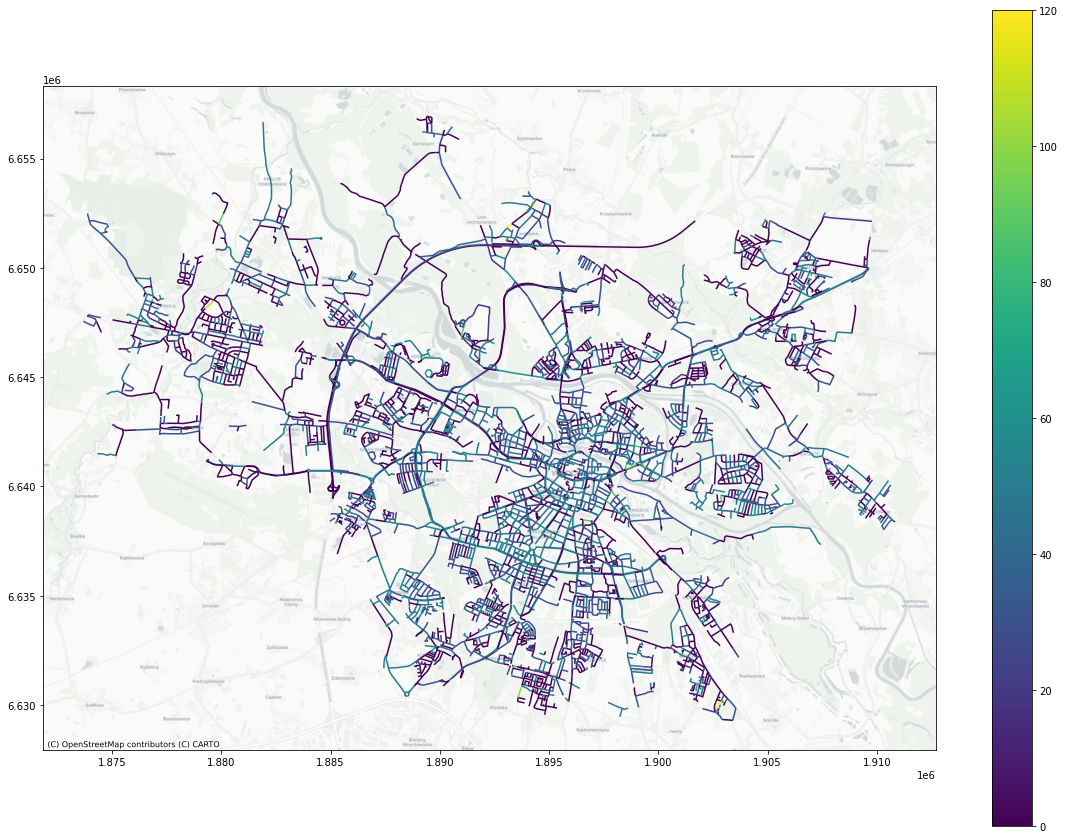

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.set_aspect('equal')
# hex_gdf.plot(column='cluster', ax=ax)
# hexagons_clustered.to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
# hexagons_clustered[hexagons_clustered["cluster"] != -1].to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
ble2["geometry"] = ble2["geometry"].set_crs(epsg=4326)
ble2.to_crs(epsg=3857).plot(ax=ax, column="maxspeed", alpha=1, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)